# Student Gets Top 2% in Kaggle Housing Prices Competition
This as been a fun and very educational project. It took a lot of tinkering over weeks to move up the leaderboard finally peaking in the top 2% of all participants.<br>

The competition can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The goal is to use machine learning models to predict housing prices. You are given a train dataset which includes 80 features describing each house, the property, and details about the sale. It also includes housing prices. Once the models are trained you make predictions based a separate test data set that includes all the features but doesn't include the sale price. The predictions are sent to Kaggle for a score. You are only allowed 10 submissions per day, which I definately made use of!

### Acknowlegements
These resources were very helpful:
* **DataQuest**: They have a great online code along data science course. 2 modules in particular were very helpful. One covered linear regression and used the same dataset from the Ames Iowa housing market. The other covered Kaggle competitions in general using the Titanic survival prediction competition. DataQuest can be found [here](https://www.dataquest.io/).
* **Feature Engineering Udemy Course**: I took the course specifically to help me with this competition and it was a big help. It can be found [here](https://www.udemy.com/course/feature-engineering-for-machine-learning/).
* **Notebooks Uploaded to Kaggle**: There are loads of helpful notebooks uploaded where fellow Kagglers upload their own solution to this competition. I read thru many of them and implemented techniques that I felt I could actually understand. [This](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition) is one of the first notebooks I studied. It introduced me to blending scores and a lot of ideas on creating new features. [Another](https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing) good one with lots of explanations. There are many, many others.

### The Goal
Describe the process I went thru and what I learned along the way in order to cement the concepts in my mind. Also hope to solicit feedback and maybe others will find this notebook helpful. I certainly learned a lot reading other peoples notebooks.

### Preliminary Module Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.style as style

import warnings

from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

### Importing the Data
I combine the datasets into one dataframe for convenience. Will split later before training the models.

In [19]:
def build_df():
    df_train = pd.read_csv('../train.csv')
    df_test = pd.read_csv('../test.csv')

    Ids = df_test['Id']

    df_train['Train']=1
    df_test['Train']=0

    #Join datasets
    df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
    df.drop('Id', axis=1, inplace=True)
    
    return Ids, df

Ids, df = build_df()

In [20]:
df # I upgraded to python 3 which will automatically display the first 5 and last 5 rows of a dataframe
# conveniently removes the need to do df.head() and df.tail() as separate statements

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Train
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN,0
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN,0
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN,0
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN,0


80 features are a lot to keep track of but they have logical groupings which make it easier. For example the fields related to the basement:

In [21]:
[x for x in df.columns if 'Bsmt' in x]

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [22]:
df.BsmtQual.value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

BsmtQual and BsmtCond are strings that are on an ordinal scale from Po = Poor to Ex = Excellent. Then you have a lot of features with SF in the name that are various ways of measuring the size of the basement in square feet. Then you have a couple of features that count bathrooms.

In [23]:
df.BsmtFinType1.value_counts()

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64

**From the Data Dictionary on BsmtFinType1 and BsmtFinType2**       
       
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

So BsmtFinType1 and 2 rank the basement on a different ordinal scale. There are 2 features in case you have 2 sections of the basement that can be described differently. There are similar features for the Garage, the house in general etc. Having the data dictionary open and referring to it often definately helps.

### Settings
I used settings as a way to keep track of the changes I was making. In my first notebook I found myself in a situation where I lost track of changes I had made to get a temporary best score, and couldn't find my way back. This is an attempt to prevent that problem. I don't use most of them in this notebook in order to save space. But using settings and adding them to a csv file for each Kaggle submission saved me a couple of times.<br>

Everything is inter-related. Adding a new feature may mean that the optimal model parameters change. And the optimal blend of model predictions may change as well. So it is easy to make one change, find the optimal settings based on that change, find out the change doesn't improve the Kaggle score like you'd hoped, and then forget all the changes you made.

In [24]:
RANDOM_STATE = 42

# set to true when you want to create the file with scores to submit to kaggle
submit_pred = True
kag_file_name = 'simple sub 36 - Remove Landslope'

# models: calculating best parameters
use_scaler_lgb = True
find_lgb_params = False
find_ridge_params = False
find_svr_params = False

# settings for using new features
use_has = True
use_age = True
use_exterior = False
use_condition = False
drop_features = True
total_porch_sf = False
drop_redundant_feats = False
has_count = False
near_park = False
highlight_months = False
total_livable = False

# encodings
encode_neighborhood = False
encode_month = False
encode_overallqual = False
encode_overallcond = False
discrete_to_categorical = True
ordered_int_encoding = True
one_hot_encode = True
trim_discrete = False # setting to true is surprisingly bad.  Why??? Worth investigating. blew up dbscan!
avg_grlivarea_hood = True # technically new feature but uses the encoding function

# removing features and outliers (rows)
remove_overfit_features = True
overfit_threshold = 99.94 # 99.94 default
rem_outliers_visual = True
rem_outliers_dbscan = True
dbscan_eps = 25
dbscan_min_samples = 80
additional_outliers = [30, 462, 631, 1322]

# adjusting predictions
down_grade_factor = .75 # was .84 significant improvement
upgrade_factor = 1.10 # 1.02 default 1.08 improvement
upper_limit = 450000
lower_limit = 60000 # default 60000

# multicollinearity
reduce_vif = False
pca = False

### Transform Target
The one modification that made the biggest impact was taking the log of SalePrice. The most common modification I saw in the Kaggle notebooks was log1p. I have also seen ln and log10 used. I don't think it makes much difference which is used, just remember to undo the transformation before sending in the final predictions.

In [25]:
def visualize_target(df, target): 
    fig = plt.figure(constrained_layout=True, figsize=(14,7))
    grid = gridspec.GridSpec(ncols=5, nrows=4, figure=fig)
    
    ax1 = fig.add_subplot(grid[0, 2:4])
    ax1.set_title('Histogram') 
    sns.distplot(df.loc[:, target], norm_hist=True, ax = ax1, fit=norm)

    ax2 = fig.add_subplot(grid[1, 2:4]) 
    ax2.set_title('QQ_plot') 
    stats.probplot(df.loc[:, target], plot = ax2)

    ax3 = fig.add_subplot(grid[:, 4])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:, target], orient='v', ax = ax3 )
    
    my_corrs = df.corr()[target].sort_values(ascending=False)[1:11].to_frame()
    
    ax4 = fig.add_subplot(grid[:, 0]) 
    ax4.set_title(target.upper() + ':\ncorrelations')
    sns.heatmap(data=my_corrs, annot=True, cbar=False)
    
    plt.show()

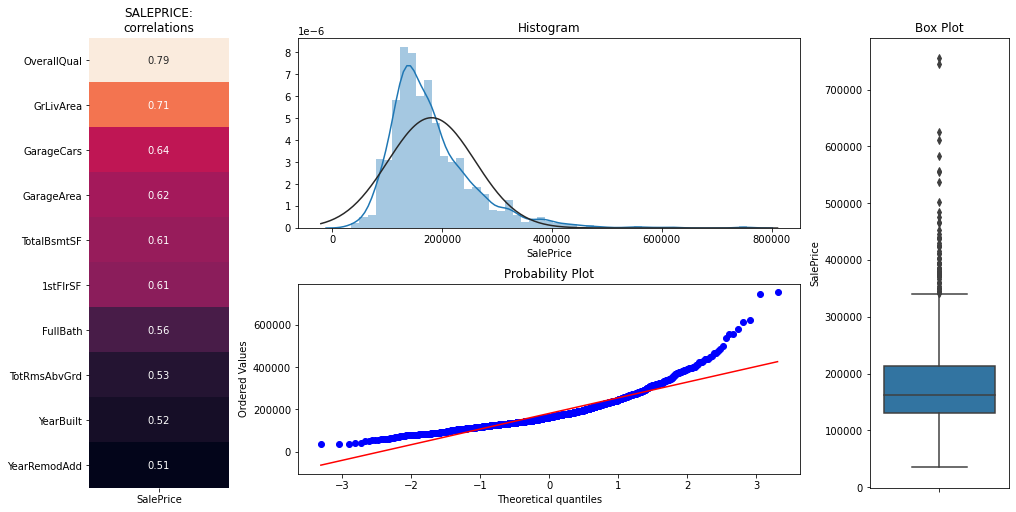

In [26]:
visualize_target(df[df.Train==1], 'SalePrice')

Very much skewed to the right with all the outliers above the mean. This is understandable for a housing market with a handful of very large, very expensive homes pulling the mean to the right and a larger group of affordable homes below the mean pulling the median to the left.<br>

In the end we will end up "reskewing" the final predictions by increasing the SalePrice on the top predictions and lowering those predictions on the cheaper houses. It's not enough to just undo the log transformation. 

Looking at the features that correlate well with SalePrice confirms general expectations of how housing markets would work. People want large quality houses with garages, basements, and lots of bathrooms. People prefer newer houses unless in some cases they are old enough to be considered "historic".

In [27]:
df['SalePrice'] = np.log1p(df.SalePrice)

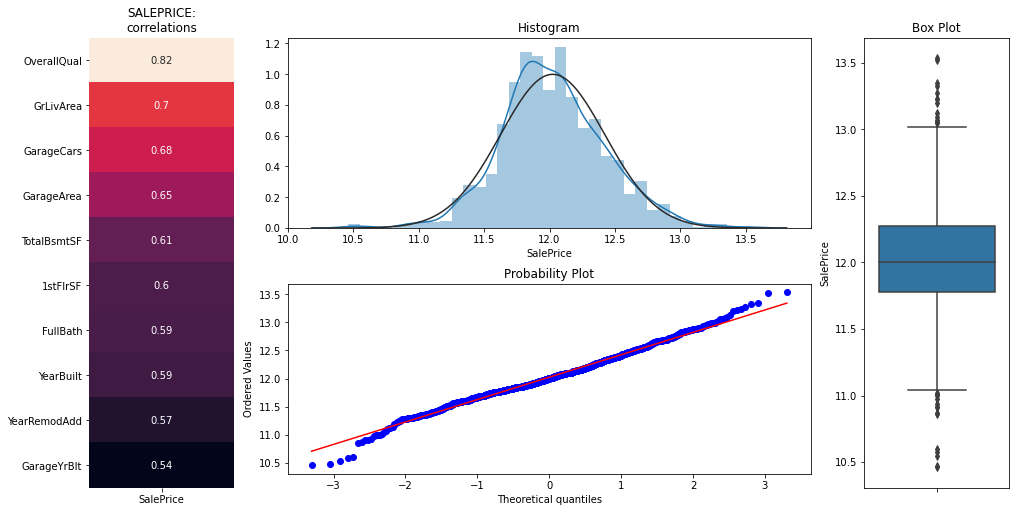

In [28]:
visualize_target(df[df.Train==1], 'SalePrice')

Much more of a normal distribution now.

### Fill Nulls
Sklearn's linear regression models can't handle null values. This is a pretty simple approach to handling null values. I tried going into more detail, but it didn't help.

In [29]:
def fill_nulls1(df): 
    missing_val_col = ["Alley", 
                       "PoolQC", 
                       "MiscFeature",
                       "Fence",
                       "FireplaceQu",
                       "GarageType",
                       "GarageFinish",
                       "GarageQual",
                       "GarageCond",
                       'BsmtQual',
                       'BsmtCond',
                       'BsmtExposure',
                       'BsmtFinType1',
                       'BsmtFinType2',
                       'MasVnrType']

    for i in missing_val_col:
        df[i] = df[i].fillna('None')
        
    missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

    for i in missing_val_col2:
        df[i] = df[i].fillna(0)
        
    ## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))
    
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    df['Functional'] = df['Functional'].fillna('Typ') 
    df['Utilities'] = df['Utilities'].fillna('AllPub') 
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0]) 
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    df['KitchenQual'] = df['KitchenQual'].fillna("TA") 
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    df['Electrical'] = df['Electrical'].fillna("SBrkr") 
    
    print(df.drop('SalePrice', axis=1).isnull().sum().sum(), 'nulls remain')
    return df

In the data dictionary NA is listed as the value for GarageQual and GarageCond that indicates there is no garage. However in the data no NA values exist and there are a lot of null values. We can therefor make a resonable assumption that "NA" or "None" would be the appropriate value to use to replace null values in these columns. Likewise 0 is the appropriate value to fill nulls in columns like GarageArea and GarageCars.<br>

For other values you can fill with either the mean or the most common value (mode) for that feaure. Or you can pick the mean or mode for the feature grouped by the Neighborhood or another related column. For example with MSZoning I pick the most common value for the MSSubClass to fill nulls because Zoning is related to SubClass.<br>

For features like Functional that have one value that is much more common than the others, I just fill with that value.

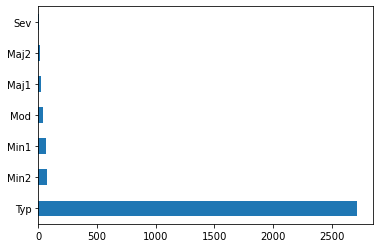

In [30]:
df.Functional.value_counts().plot.barh();

Typ is much more common than all other possible values so we can use it to fillna for Functional. Below we can see the most common value of MSZoning differs by MSSubClass.

In [31]:
df.groupby('MSSubClass')['MSZoning'].apply(lambda x: x.mode()[0]).to_frame()

,MSZoning
MSSubClass,
20,RL
30,RM
40,RL
45,RM
50,RL
60,RL
70,RM
75,RM
80,RL


The dataframe group by method may seem a little busy and complicated at first but it is very useful once you get the hang of it. 

In [32]:
df.groupby("MSSubClass")

In [33]:
grp_by_list = [g for g in df.groupby("MSSubClass")]
grp_by_list

[(20,
        MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
  1             20       RL         80.0     9600   Pave   NaN      Reg   
  6             20       RL         75.0    10084   Pave   NaN      Reg   
  10            20       RL         70.0    11200   Pave   NaN      Reg   
  12            20       RL          NaN    12968   Pave   NaN      IR2   
  13            20       RL         91.0    10652   Pave   NaN      IR1   
  ...          ...      ...          ...      ...    ...   ...      ...   
  2903          20       RL         88.0    11577   Pave   NaN      Reg   
  2904          20      NaN        125.0    31250   Pave   NaN      Reg   
  2907          20       RL         58.0    10172   Pave   NaN      IR1   
  2911          20       RL         80.0    13384   Pave   NaN      Reg   
  2916          20       RL        160.0    20000   Pave   NaN      Reg   
  
       LandContour Utilities LotConfig  ... PoolQC Fence MiscFeature MiscVal  \
  1        

So for every value of MSSubClass you get the value and a filtered dataframe of all rows where MSSubClass equals that value. 

In [34]:
grp_by_list2 = [g for g in df.groupby("MSSubClass")['MSZoning']]
grp_by_list2

[(20,
  1        RL
  6        RL
  10       RL
  12       RL
  13       RL
         ... 
  2903     RL
  2904    NaN
  2907     RL
  2911     RL
  2916     RL
  Name: MSZoning, Length: 1079, dtype: object),
 (30,
  29           RM
  68           RM
  92           RL
  98           RL
  106          RM
           ...   
  2871         RL
  2886         RM
  2888         RM
  2889         RM
  2891    C (all)
  Name: MSZoning, Length: 139, dtype: object),
 (40,
  164     RM
  589     RM
  873     RL
  1270    RL
  2454    RL
  2554    RL
  Name: MSZoning, dtype: object),
 (45,
  15      RM
  21      RM
  127     RM
  163     RL
  325     RM
  383     RH
  437     RM
  514     RL
  555     RM
  617     RL
  826     RM
  1069    RL
  1533    RM
  2079    RL
  2118    RM
  2397    RL
  2458    RM
  2467    RM
  Name: MSZoning, dtype: object),
 (50,
  5            RL
  8            RM
  46           RL
  51           RM
  69           RL
           ...   
  2881         RL
  2882         RL

Limiting it to just the MSZoning values

In [35]:
df.groupby('MSSubClass')['MSZoning'].apply(lambda x: x.mode()[0])

MSSubClass
20     RL
30     RM
40     RL
45     RM
50     RL
60     RL
70     RM
75     RM
80     RL
85     RL
90     RL
120    RL
150    RL
160    RM
180    RM
190    RL
Name: MSZoning, dtype: object

Now instead of getting a list of MSZoning values we get just the most common value. To frame converts the series to a dataframe which looks much nicer in a jupyter notebook.

In [36]:
df = fill_nulls1(df)

0 nulls remain


All nulls removed

### Skewed Features
After taking a log transformation of the target variable, the next action that had the biggest impact is probably taking a boxcox transformation of skewed features. GrLivArea is a great example of a skewed feature.

In [37]:
def examine_feature(data, feature, target, std_count=3, show_outliers=False): 
    df = data.copy()
    
    fig = plt.figure(constrained_layout=True, figsize=(14,7))
    grid = gridspec.GridSpec(ncols=5, nrows=4, figure=fig)
    
    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, 2:4])
    ax1.set_title('Histogram') 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1, fit=norm)

    # scatterplot
    upper_boundary = df[feature].mean() + std_count * df[feature].std()
    lower_boundary = df[feature].mean() - std_count * df[feature].std()
    
    df['Outlier'] = np.where((df[feature] > upper_boundary) | (df[feature] < lower_boundary), 'Outlier', 'Non-Outlier')
    ax2 = fig.add_subplot(grid[1, 2:4]) 
    ax2.set_title(f'Scatter Plot vs {target}') 
    ax2.axvline(upper_boundary, color='g', alpha=0.3)
    ax2.axvline(lower_boundary, color='g', alpha=0.3)
    sns.scatterplot(data=df, x=feature, y=target, hue='Outlier', ax=ax2)
#     sns.lmplot(data=df, x=feature, y=target, hue='Outlier', ax=ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 4])
    ax3.set_title('Box Plot')
    ax3.axhline(upper_boundary, color='g', alpha=0.3)
    ax3.axhline(lower_boundary, color='g', alpha=0.3)
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 )
    
    my_corrs = df.corr()[feature].sort_values(ascending=False)[1:11].to_frame()
    
    ax4 = fig.add_subplot(grid[:, 0]) 
    ax4.set_title(feature.upper() + ' PLOTS:\n Correlations')
    sns.heatmap(data=my_corrs, annot=True, cbar=False)
    
    plt.show()
    
    if show_outliers:
        print('Outliers\n----------------')
        return df.loc[df.Outlier=='Outlier', [feature, 'SalePrice', 'OverallQual', 'OverallCond', 
                                              'GarageCars', 'Functional']].sort_values(by=feature)

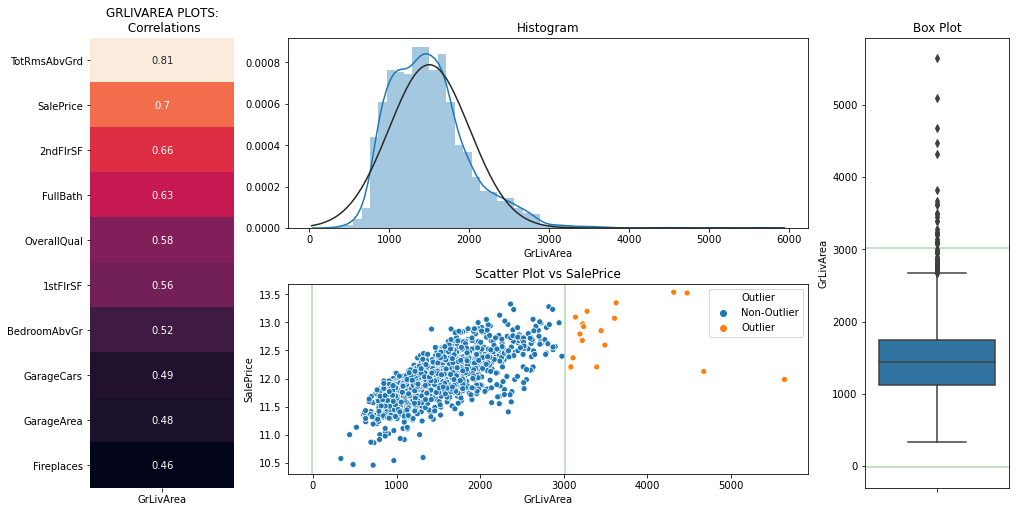

In [38]:
examine_feature(df, 'GrLivArea', 'SalePrice', 3, False)

We can see GrLivArea is skewed to the right with some really large houses apparently.

In [39]:
def fix_skew(df, threshold=.75): 
    num_cols = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > threshold]
    skewed_features = high_skew.index
    print('skewed features\n', skewed_features, '\n')
    
    lam_d = {}

    for feat in skewed_features:
        if df[feat].min() > 0:
            x, lam = stats.boxcox(df[feat])
            lam_d[feat] = lam
            df[feat] = x
        else:
            lam_d[feat] = 0.2
            df[feat] = boxcox1p(df[feat], 0.2)
    
    print('lambdas used\n')
    print(lam_d)
    return df, skewed_features
        
df, skewed_feats = fix_skew(df)

skewed features
 Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', '1stFlrSF',
       'LotFrontage', 'BsmtFinSF1', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF',
       '2ndFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt'],
      dtype='object') 

lambdas used

{'MiscVal': 0.2, 'PoolArea': 0.2, 'LotArea': 0.1300615674135057, 'LowQualFinSF': 0.2, '3SsnPorch': 0.2, 'KitchenAbvGr': 0.2, 'BsmtFinSF2': 0.2, 'EnclosedPorch': 0.2, 'ScreenPorch': 0.2, 'BsmtHalfBath': 0.2, 'MasVnrArea': 0.2, 'OpenPorchSF': 0.2, 'WoodDeckSF': 0.2, '1stFlrSF': -0.06241247624480627, 'LotFrontage': 0.5912076662674711, 'BsmtFinSF1': 0.2, 'GrLivArea': -0.011741655231629719, 'TotalBsmtSF': 0.2, 'BsmtUnfSF': 0.2, '2ndFlrSF': 0.2, 'TotRmsAbvGrd': 0.10514676751530015, 'GarageYrBlt': 0.2}


I tried using boxcox_normax to find the ideal value for lam but it just doesn't work as well as just using 0.2 for features that contain 0. Stats.boxcox is nice because it finds the idea value of lam for you, but it doesn't work with features that contain a 0.

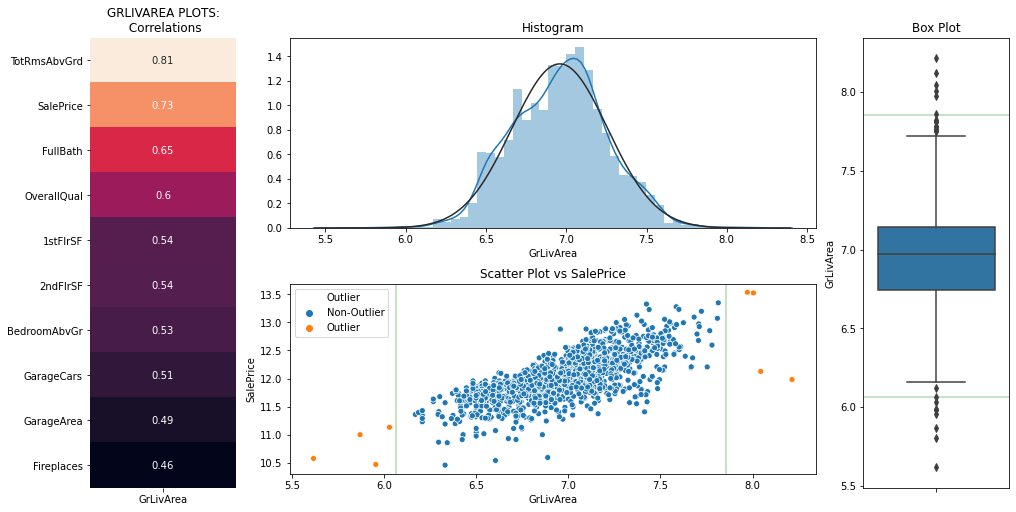

Outliers
----------------


,GrLivArea,SalePrice,OverallQual,OverallCond,GarageCars,Functional
533,5.617320,10.579005,1,3,0.0,Typ
2098,5.801740,NaN,2,5,1.0,Typ
1100,5.870116,11.002117,2,5,1.0,Typ
916,5.955326,10.471978,2,3,1.0,Typ
2785,5.978289,NaN,3,5,1.0,Typ
2871,5.989559,NaN,2,3,1.0,Typ
29,6.029737,11.134604,4,6,1.0,Typ
2188,7.861202,NaN,5,7,2.0,Typ
691,7.971933,13.534474,10,6,3.0,Typ
1182,8.004920,13.521141,10,5,3.0,Typ


In [40]:
examine_feature(df, 'GrLivArea', 'SalePrice', 3, True)

You can see a big difference in the distribution and outliers of GrLivArea skewed vs transformed. DBScan run later will find outlier 1298. We will signify 691 and 1182 as outliers to be removed. Strangely, removing outlier 523 hurts the score. Not sure why, it clearly looks to be an outlier. It is one of the largest houses in the dataset with OverallQual of 10 and yet it sells for an average price.

In [41]:
grlivarea_outliers = [691, 1182]

### Feature Types

In [42]:
# borrowed from Feature Engineering Udemy course
categorical = [var for var in df.columns if df[var].dtype == 'O']

year_vars = [var for var in df.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in df.columns if df[var].dtype != 'O'
    and len(df[var].unique()) < 20 and var not in year_vars
    and var != 'Train'
]

numerical = [
    var for var in df.columns if df[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice', 'Train']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 13 discrete variables
There are 4 temporal variables
There are 44 categorical variables


In [43]:
# skewed features handled. Need to look at discrete features that weren't handled
remain_discrete = [x for x in discrete if x not in skewed_feats]
remain_discrete

['OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'Fireplaces',
 'GarageCars',
 'MoSold']

In [44]:
if discrete_to_categorical:
    df[remain_discrete] = df[remain_discrete].astype('O')

In [45]:
cat_encode_list = categorical + remain_discrete

# the following don't have enough values to be worth categorical encoding. In fact will error
# because labels exist in train that are not in holdout
cat_encode_list.remove('MSSubClass')
cat_encode_list.remove('FullBath')
cat_encode_list.remove('Fireplaces')
cat_encode_list.remove('GarageCars')
    
at_least_5 = [x for x in cat_encode_list if df.loc[df.Train==1, x].nunique() >= 5]
at_least_5.sort()
# at_least_5

Will use Ordered Integer Encoding on cat_encode_list

### Ordered Integer Encoding
Ordered integer encoding transforms existing values into integer list 1, 2, 3... in order of mean sale price for each value. This creates a linear or at least monotonic (always increasing or always decreasing) relationship between the feature and the target. This is useful for categorical variables because these values need to be numerical and putting them in order of avg SalePrice gives it as close to a linear relationship with SalePrice as you can get.<br>

We also encode some discrete values this way if they are not in a good order. Below is an example using Neighborhood. I learned Ordered Int Encoding from the Feature Engineering Udemy course. It is easy to understand and made a big difference in the Kaggle score. Glad I took the course!

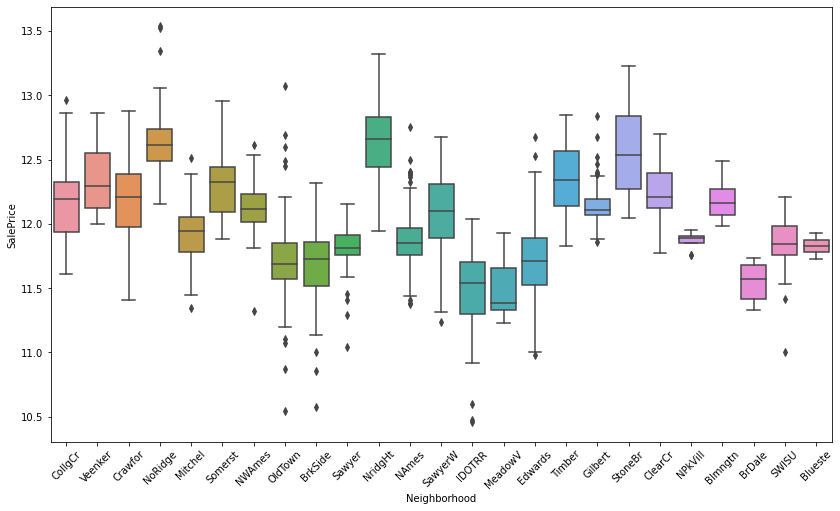

In [46]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df[df.Train==1], x='Neighborhood', y='SalePrice')
plt.xticks(rotation=45)
plt.show()

This is the "before" graph of neighborhood. You can see that there is a big difference in distributions of SalePrice from one Neighborhood to the next, but it is not in a nice order and we want the values for Neighborhood to be numerical.

In [47]:
def find_category_mappings(df, variable, target):

    # first  we generate an ordered list with the labels
    ordered_labels = df.groupby([variable])[target].mean().sort_values().index

    # return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}
    
def integer_encode(df, feature, ordinal_mapping):
    df[feature] = df[feature].map(ordinal_mapping)
    return df

In [48]:
# df['Hood'] = df.Neighborhood # want it to be one hot encoded later ... didn't work :( 

for feat in cat_encode_list:
    mappings = find_category_mappings(df[df.Train==1], feat, 'SalePrice')
    df = integer_encode(df, feat, mappings)

Neighborhood after encoding. Much nicer!

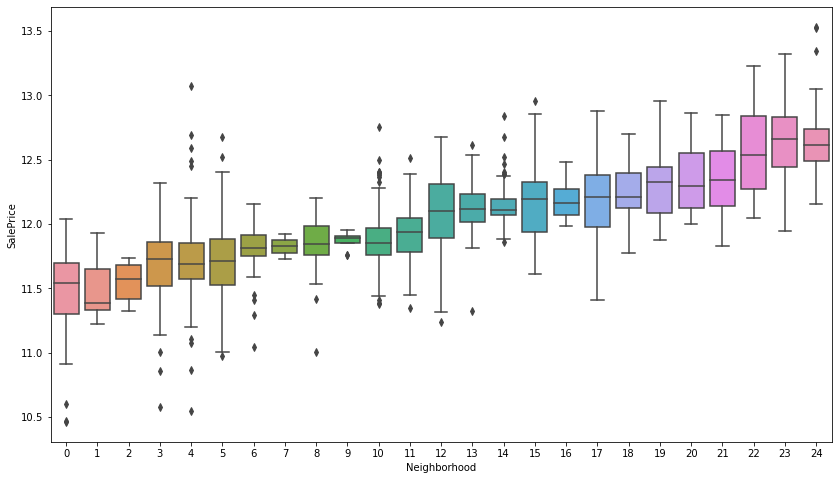

In [49]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df[df.Train==1], x='Neighborhood', y='SalePrice')
plt.show()

### Create New Features and Drop Existing Features
This is the fun part! But it can also be very frustrating. When you create a new feature it can affect the optimal values of model parameters, model weighted averages for blended prices, and other parameters. So you can end up optimizing everything based on the new feature only to find it doesn't improve the overall score. But those times that do improve the score make it all worthwhile :)<br>

The basic premise seems to be people like big quality homes in good condition in nice neighborhoods. They also seem to like historic homes but not necessarily homes that are just old.

In [50]:
df['TotalSF'] = (df['TotalBsmtSF'] 
                       + df['1stFlrSF'] 
                       + df['2ndFlrSF'])

df['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
                                 

df['Total_Bathrooms'] = (df['FullBath'] 
                               + (0.5 * df['HalfBath']) 
                               + df['BsmtFullBath'] 
                               + (0.5 * df['BsmtHalfBath'])
                              )

# adding Qual and Cond works better than multiplying them. Don't know why.
df['QualCond'] = df.OverallQual + df.OverallCond
df['ExterQualCond'] = df.ExterQual + df.ExterCond
df['GarageQualCond'] = df.GarageQual + df.GarageCond
df['BsmtQualCond'] = df.BsmtQual + df.BsmtCond

df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
df['house_age'] = df.YrSold - df.YearBuilt
df['garage_age'] = df.YrSold - df.GarageYrBlt
df['old_house'] = np.where(df.YearBuilt < 1900, 1, 0)

# from feature engineering course udemy
def find_category_mappings(df, variable, target):
    return df.groupby([variable])[target].mean().to_dict()

# lots of big homes in the neighborhood? How does the home compare to the neighborhood in this regard?
hm = find_category_mappings(df[df.Train==1], 'Neighborhood', 'GrLivArea')
df['avg_grlivarea_hood'] = df.Neighborhood.map(hm)
df['grlivarea_vs_hood_avg'] = (df.GrLivArea / df.avg_grlivarea_hood)
df['gt_avg_area_hood'] = np.where(df.GrLivArea > df.avg_grlivarea_hood, 1, 0)

# features dominated by one value
df.drop(['Utilities', 'Street', 'PoolQC'], axis=1, inplace=True)

I love np.where, used for df.old_house above, and find myself using it more and more and avoiding the apply method if I can. It is easier for me to remember how it works.

Tried polynomials. Does not seem to help. You find them in many of the Kaggle notebooks.

In [51]:
# df['OverallQual_2'] = df.OverallQual ** 2
# df['OverallQual_3'] = df.OverallQual ** 3
# df['OverallQual_sqrt'] = np.sqrt(df.OverallQual)

### One Hot Encoding
The feature_engine object was created for the Udemy Feature Engineering course. It seems to work pretty well so I use it here. The other options are the sklearn hot encoding object or just using pd.get_dummies. The latter is the simplest but feature_engine does give a better Kaggle score. Here is the documentation [feature engine](https://feature-engine.readthedocs.io/en/latest/)

In [52]:
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

ohe_enc = OneHotCategoricalEncoder(
    top_categories=None,
    drop_last=True) # to return k-1, false to return k

# # fit on train then encode both
ohe_enc.fit(df[df.Train==1])

df = ohe_enc.transform(df)

### Remove Overfitted Features
I borrowed this function directly from one of the Kaggle notebooks. Unfortunately I don't remember which one. Interesting that the threshold is so high.

In [53]:
def overfit_reducer(df, threshold=99.94):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > overfit_threshold:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

overfitted_features = overfit_reducer(df, overfit_threshold)
print(overfitted_features)
df = df.drop(overfitted_features, axis=1)

['Total_Bathrooms_1.1143273490387933']


Only one feature was removed. We can also see that feature engine did something interesting with Total_Bathrooms. There was no original value of 1.1143... 

### Outliers
This is another area that makes a big difference. Lots of different ways of identifying outliers and hard to pick the perfect list. However, removing certain rows from the train data can improve the overall performance of the models.<br>

Tried a number of different techniques to identify outliers and dbscan worked the best. The trick is there is a narrow range of parameter values that will give you good results. Most combinations will identify no outliers or identify all records as outliers.

In [54]:
# found earlier by visually inspecting the data
df.drop(grlivarea_outliers, axis=0, inplace=True)

In [55]:
def remove_outliers_dbscan(df, eps=40, min_samples=80):
    from sklearn.cluster import dbscan
    scaler = StandardScaler()
    to_scale = df[df.Train==1].drop('SalePrice', axis=1)
    scaled = scaler.fit_transform(to_scale)
    cd = df.loc[df.Train==1]
    db = dbscan(scaled, eps=dbscan_eps, min_samples=dbscan_min_samples)
    cs = pd.Series(db[1])
    cs.index = cd.index
    db_scan_outliers = cs[cs==-1].index
    print('outliers from dbscan:', db_scan_outliers)
    return df.drop(db_scan_outliers), db_scan_outliers, cs

In [56]:
df, db_scan_outliers, clusters = remove_outliers_dbscan(df, dbscan_eps, dbscan_min_samples)

outliers from dbscan: Int64Index([298, 628, 921, 954, 1154, 1230, 1298, 1386], dtype='int64')


Dbscan identified 2 clusters. 0 = not an outlier. -1 = outlier.

In [57]:
clusters.value_counts()

 0    1450
-1       8
dtype: int64

The following outliers were taken from notebooks uploaded to Kaggle. I wish I could explain how they were obtained. The person who uploaded the notebook found them from another notebook(s).

In [58]:
additional_outliers = [30, 462, 631, 1322]
df.drop(additional_outliers, axis=0, inplace=True)

### Getting Ready for the Machine Learning Models
Finally. We are almost ready to make some predictions. Functions get_cv_scores and train_and_test are from the DataQuest course, but may have been modified a little. 

In [59]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

def split_data(df):
    holdout = df[df.Train==0].drop(['SalePrice', 'Train'], axis=1)
    y = df.loc[df.Train==1, 'SalePrice']
    x = df[df.Train==1].drop(['SalePrice', 'Train'], axis=1)
    
    return x, y, holdout

def get_cv_scores(model):
    cv = KFold(shuffle=True, random_state=2, n_splits=10)
    scores = cross_val_score(model,
                             x,
                             y,
                             cv=cv,
                             scoring='r2')

    print(f'\nR-Squared: {np.mean(scores):.5f} +/- {np.std(scores):.5f} ')
    print(f'RMSE: {np.sqrt(mean_squared_error(y, model.predict(x))):.5f}')
    
def get_cv_scores_svr(model):
    cv = KFold(shuffle=True, random_state=2, n_splits=10)
    scores = cross_val_score(model,
                             x_svr,
                             y,
                             cv=cv,
                             scoring='r2')

    print(f'\nR-Squared: {np.mean(scores):.5f} +/- {np.std(scores):.5f} ')
    print(f'RMSE: {np.sqrt(mean_squared_error(y, model.predict(x_svr))):.5f}')

def get_used_features(fit_model, feature_cols):
  coef_df = pd.Series(dtype='float')

  for coef, col in enumerate(feature_cols):
    c = fit_model.coef_[coef]
    if c > 0:
      coef_df[col] = c
  return pd.DataFrame(coef_df, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

def get_unused_features(fit_model, feature_cols):
    coef_df = pd.Series(dtype='float')

    for coef, col in enumerate(feature_cols):
        c = fit_model.coef_[coef]
        if c == 0:
          coef_df[col] = c
        
    return pd.DataFrame(coef_df, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

def train_and_test(model, param_grid):
    ''' Find the best prams for the model based on choices given in param_grid '''
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', 
                        verbose=1, n_jobs=-1)
    grid_result = grid.fit(x, y)
    print('\nBest Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    
def make_kaggle_file(predictions, Ids, filename):
    df = pd.DataFrame()
    df['Id'] = Ids
    df['SalePrice'] = predictions
    df.to_csv(f'submissions\{filename}.csv', index=False)

In [60]:
x, y, holdout = split_data(df)

In [61]:
x.shape

(1446, 129)

### Ridge Model

In [62]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

In [63]:
ridge = Ridge(alpha=1, random_state=RANDOM_STATE).fit(x,y)
alpha = [1e-07, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 8, 9, 9.5,10, 10.5, 11,  15, 19, 20]
# alpha = [.0001, .001, .01, .1, 1, 1.5, 2, 9]
solver = ['auto']
param_grid = dict(alpha=alpha, solver=solver)

if find_ridge_params:
    train_and_test(ridge, param_grid)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.1s



Best Score:  0.9007976236940747
Best Params:  {'alpha': 5, 'solver': 'auto'}


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.0s finished


The train_and_test function uses GridSearchCV and the parameter grid to find the best performing parameter values. However the ultimate judge is the Kaggle score so I end up changing a parameter for each model from the one recommended by GridSearchCV. In this case 5 is recommended for alpha, but I got better results with 9.<br>

In [64]:
ridge_alpha = 9

ridge_setup = Ridge(alpha=ridge_alpha, solver='auto', random_state=RANDOM_STATE)
ridge = make_pipeline(RobustScaler(), ridge_setup).fit(x,y)
get_cv_scores(ridge)


R-Squared: 0.90235 +/- 0.01748 
RMSE: 0.11110


get_cv_scores uses cross fold validation to get the best R2 and RMSE scores you can with the train data. R2 is a measure of how much of the overall variation in SalePrice your model explains. The higher the better. RMSE is the square root of the mean of the squared errors, where error is the difference between the predicted SalePrice and the actual SalePrice. The lower the better.<br>

These can be used to help assess the effect of changes to the process like adding new features. However the true judge again is the Kaggle score and sometimes these scores don't predict what will happen with the Kaggle score.

In [65]:
ridge_pred = np.expm1(ridge.predict(holdout))
ridge_pred

array([121829.82555239, 172468.09821208, 181946.77958316, ...,
       160391.87216322, 129603.82721133, 225316.55336205])

### Light Gradient Booster

In [66]:
lgb_estimators = 5000 # 5000 new best
loss = 'huber' # huber helps when you have a lot of outliers

In [67]:
from lightgbm import LGBMRegressor

if find_lgb_params:
    lgbr = LGBMRegressor(objective='regression', learning_rate = 0.1)
    learning_rate=[0.008, 0.009, 0.01]
    num_leaves = [8, 9, 10]
    n_estimators = [lgb_estimators]
    max_bin = [100]
    bagging_fraction = [0.4]
    bagging_freq = [5]
    feature_fraction = [0.2]
    feature_fraction_seed = [8, 9]
    bagging_seed = [9]
    min_data_in_leaf = [6, 7, 8]
    min_sum_hessian_in_leaf = [8, 9, 10]
    loss = ['huber']

    param_grid = dict(learning_rate=learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_bin=max_bin,
                     bagging_fraction=bagging_fraction, bagging_freq=bagging_freq, feature_fraction=feature_fraction,
                     feature_fraction_seed=feature_fraction_seed, bagging_seed=bagging_seed, min_data_in_leaf=min_data_in_leaf,
                     min_sum_hessian_in_leaf=min_sum_hessian_in_leaf, loss=loss)
    train_and_test(lgbr, param_grid)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 11.5min finished



Best Score:  0.9158825144266738
Best Params:  {'bagging_fraction': 0.4, 'bagging_freq': 5, 'bagging_seed': 9, 'feature_fraction': 0.2, 'feature_fraction_seed': 8, 'learning_rate': 0.008, 'loss': 'huber', 'max_bin': 100, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 10, 'n_estimators': 5000, 'num_leaves': 8}


5000 is a lot more estimators than GridSearchCV recommends.

In [68]:
bagging_fraction = 0.4, # 0.4 default
bagging_freq = 5, # 5 default
bagging_seed = 9, # 9 default
feature_fraction = 0.2, # 0.2 default

feature_fraction_seed = 9, # 8 default

learning_rate = 0.008, # 0.008 default
max_bin = 100, # 100 default
min_data_in_leaf = 8, # 6 default
min_sum_hessian_in_leaf = 10, # 10 default
num_leaves = 9 # 8 default

In [69]:
lgb_setup = LGBMRegressor(objective='regression',
                              bagging_fraction = bagging_fraction,
                              bagging_freq = bagging_freq,
                              bagging_seed = bagging_seed,
                              feature_fraction = feature_fraction,
                              feature_fraction_seed = feature_fraction_seed,
                              learning_rate = learning_rate,
                              max_bin = max_bin,
                              min_data_in_leaf = min_data_in_leaf,
                              min_sum_hessian_in_leaf = min_sum_hessian_in_leaf,
                              n_estimators = lgb_estimators,
                              num_leaves = num_leaves,
                              loss=loss)


lgb = make_pipeline(RobustScaler(), lgb_setup).fit(x,y)
get_cv_scores(lgb)


R-Squared: 0.91492 +/- 0.01692 
RMSE: 0.04716


In [70]:
lgb_pred = np.expm1(lgb.predict(holdout))
lgb_pred

array([124032.95374013, 158490.76937386, 184756.44373373, ...,
       157545.69072707, 121271.14574832, 195345.0253423 ])

### SVR
This is the final model we will use. It doesn't get good results on it's own, but when you blend it's predictions in with the other models predictions, it helps a little.

In [71]:
from sklearn.svm import SVR

In [72]:
if find_svr_params:
    svr = SVR(C= 20, epsilon= 0.008, gamma=0.0003)
    C = [5000] # dropped 18, 19, 20, 21, 22, 23, 24,25, 26, 27, 28, 29, 30, 32, 34, 36, 38, 40, 44,
    epsilon = [ 0.015, 0.02, 0.025] # dropped 0.0085, 0.009,
    gamma = [3e-06, 5e-06, 7e-06, 9e-06, 1.1e-05, 3e-05] # dropped , 1.45e-05, 1.5e-05, 1.2e-05, 1.3e-05, 1.4e-05
    param_grid = dict(C=C, epsilon=epsilon, gamma=gamma)
    
    train_and_test(svr, param_grid)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.6min finished



Best Score:  0.8748430972968672
Best Params:  {'C': 5000, 'epsilon': 0.025, 'gamma': 3e-06}


In [73]:
svr_c = 5000 # 23 is default
svr_epsilon = 0.025 # 0.02 default
svr_gamma = .0002 # 3e-05 default .0002 was used to get best score, lowers rmse, destroys r2

svr_setup = SVR(C=svr_c, epsilon=svr_epsilon, gamma=svr_gamma)
svr = make_pipeline(RobustScaler(), svr_setup).fit(x,y)

In [74]:
get_cv_scores(svr)


R-Squared: 0.84547 +/- 0.03208 
RMSE: 0.04724


In [75]:
svr_pred = np.expm1(svr.predict(holdout))
svr_pred

array([130950.69455094, 247249.17303231, 203595.41060033, ...,
       172225.84090336, 193516.87901013, 223235.37393139])

### Blends
Blends are a way of getting ensemble predictions by taking a weighted average of predictions from different models. From what I understand it is best to use a few very different models than a bunch of different models. The idea is the different models will each have different strengths and weakness, so taking an overall averge will be better than any of the models on their own. Ridge, Light Gradient Boost, and SVR was the blend I found that worked the best.

In [76]:
blend_pred = 0.65 * lgb_pred + 0.25 * ridge_pred + 0.10 * svr_pred # long time best blend

blend = pd.DataFrame({
    'Id': Ids,
    'SalePrice': blend_pred
})

upgrade = blend[blend.SalePrice > upper_limit].index
blend.loc[upgrade, 'SalePrice'] = blend.loc[upgrade, 'SalePrice'] * upgrade_factor

downgrade = blend[blend.SalePrice < lower_limit].index
blend.loc[downgrade, 'SalePrice'] = blend.loc[downgrade, 'SalePrice'] * down_grade_factor

In [77]:
kag_file_name = 'Pres2_sub_1'
if submit_pred:
    blend.to_csv('submissions/simple/' + kag_file_name + '.csv', index=False)

### Kaggle Score ===> 0.11412

In [78]:
kag_file_name

'Pres2_sub_1'

In [79]:
submit_pred

True

### Where To Go From Here?
I've been finding ways to keep getting a better score, but it's slow going and people keep passing me. Not sure what else to try. I think it would be fun to create a dashboard to make visualizing the features easier. I've seen where dashboards can be created in Tableau and Excel, but don't know if they can be created directly in a Jupyter Notebook.

In [80]:
98/5215

0.01879194630872483

Still in the top 2% :) Kaggle seems to drop people out of the leaderboard from time to time. I was ranked 100 yesterday, 98 today. I'll take it!

I hope this notebook was helpful to at least one person. Honestly I don't have a lot of experience teaching, explaining, or presenting to people. Mostly just crunching data with SQL behind the scenes. I really love Python however. Glad I am learning it and look forward to using it on the job in hopefully the near future. Good luck out there in your Data Science journey.